Guide - https://sbert.net/examples/sentence_transformer/applications/computing-embeddings/README.html

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import sys
sys.path.insert(0,"..")
from queuerious_detector.interpret import *

In [2]:
#load data
#train_df = pd.read_csv("../data/processed/train_tickets.csv")
#val_df = pd.read_csv("../data/processed/val_tickets.csv")
#test_df = pd.read_csv("../data/processed/test_tickets.csv")

#initialize the embedding model
#model = SentenceTransformer('all-mpnet-base-v2')

#Calculate embeddings ~3.5 hrs
#X_train = model.encode(train_df['redacted_text'].tolist())
#X_val = model.encode(val_df['redacted_text'].tolist())
#X_test = model.encode(test_df['redacted_text'].tolist())

#save embeddings
#np.save("../data/processed/X_train_sbert.npy", X_train)
#np.save("../data/processed/X_val_sbert.npy", X_val)
#np.save("../data/processed/X_test_sbert.npy", X_test)

In [ ]:
# load dfs and embeddings
train_df = pd.read_csv("../data/processed/train_tickets.csv")
val_df = pd.read_csv("../data/processed/val_tickets.csv")
test_df = pd.read_csv("../data/processed/test_tickets.csv")

X_train = np.load("../data/processed/X_train_sbert.npy")
X_val = np.load("../data/processed/X_val_sbert.npy")
X_test = np.load("../data/processed/X_test_sbert.npy")

# encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["queue_grouped"])
y_val = le.transform(val_df["queue_grouped"])
y_test = le.transform(test_df["queue_grouped"])

# initialize the classifier model
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# predict on validation and test sets
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.97      0.72      0.82       288
Customer Service, Returns & Exchanges       0.66      0.55      0.60       582
                      General Inquiry       1.00      0.15      0.26        41
                      Human Resources       1.00      0.28      0.44        60
                      Product Support       0.79      0.38      0.51       547
                  Sales and Pre-Sales       0.95      0.21      0.35        90
      Service Outages and Maintenance       0.85      0.42      0.56       120
               Technical & IT Support       0.60      0.93      0.73      1222

                             accuracy                           0.67      2950
                            macro avg       0.85      0.45      0.53      2950
                         weighted avg       0.72      0.67      0.64      2950

Test Classific

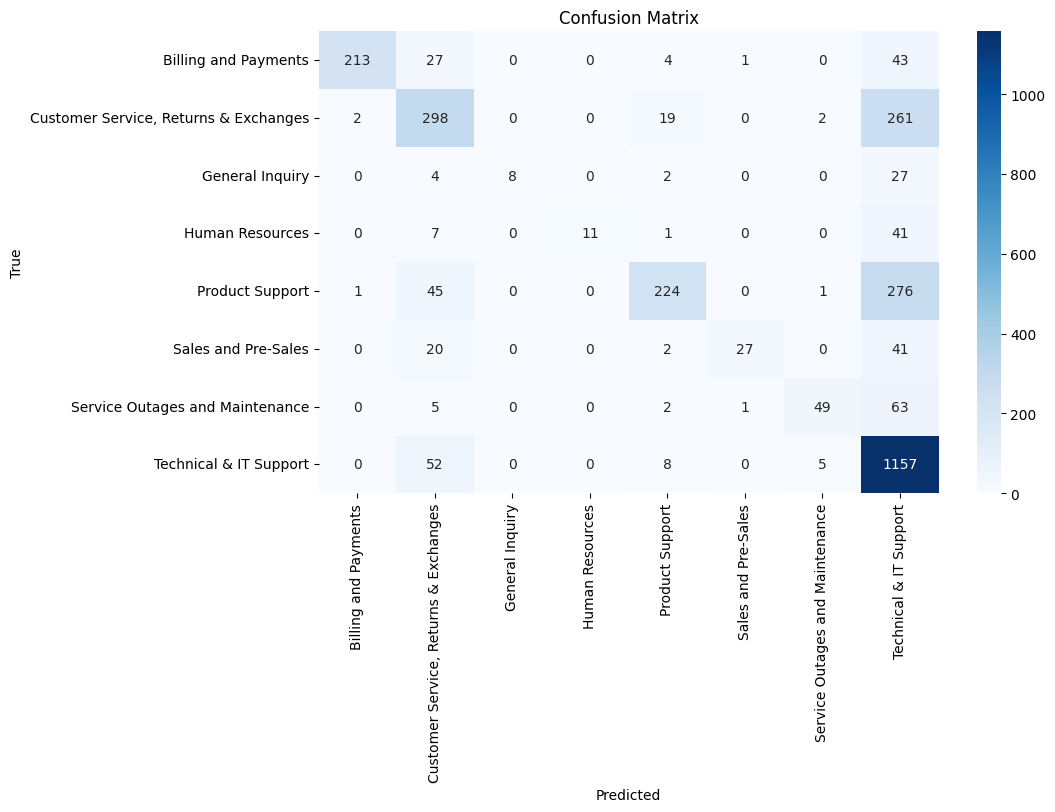

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Since Technical & IT Support make up most of the test set, many records are missclassifed as techincal & IT support. Let's try class weighting and model tuning to improve results.

In [ ]:
#how manu samples in training set?
X_train.shape

(13765, 768)

In [ ]:
#parameter tuning with RandomizedSearchCV
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [20, 40, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
}

rs = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1_weighted",
    verbose=2,
    random_state=42,
)

#subset the training data to speed up the search
subset_idx = np.random.choice(len(X_train), size=6500, replace=False)
rs.fit(X_train[subset_idx], y_train[subset_idx])

print("Best parameters found:", rs.best_params_)
print("Best weighted F1 score:", rs.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  57.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.0min
[CV] END bootstrap=False, criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, criterion=entropy, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END bootstrap=True, criterion=entropy, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END bootstrap=True, criterion=entropy, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.2min
[CV] E

In [12]:
#initialize the best model
best_model = rs.best_estimator_

#fit on the full training set
best_model.fit(X_train, y_train)

#predict on validation and test sets
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.95      0.77      0.85       288
Customer Service, Returns & Exchanges       0.59      0.63      0.61       582
                      General Inquiry       1.00      0.20      0.33        41
                      Human Resources       0.90      0.45      0.60        60
                      Product Support       0.74      0.51      0.60       547
                  Sales and Pre-Sales       0.97      0.43      0.60        90
      Service Outages and Maintenance       0.87      0.57      0.69       120
               Technical & IT Support       0.68      0.88      0.77      1222

                             accuracy                           0.71      2950
                            macro avg       0.84      0.56      0.63      2950
                         weighted avg       0.73      0.71      0.70      2950

Test Classific

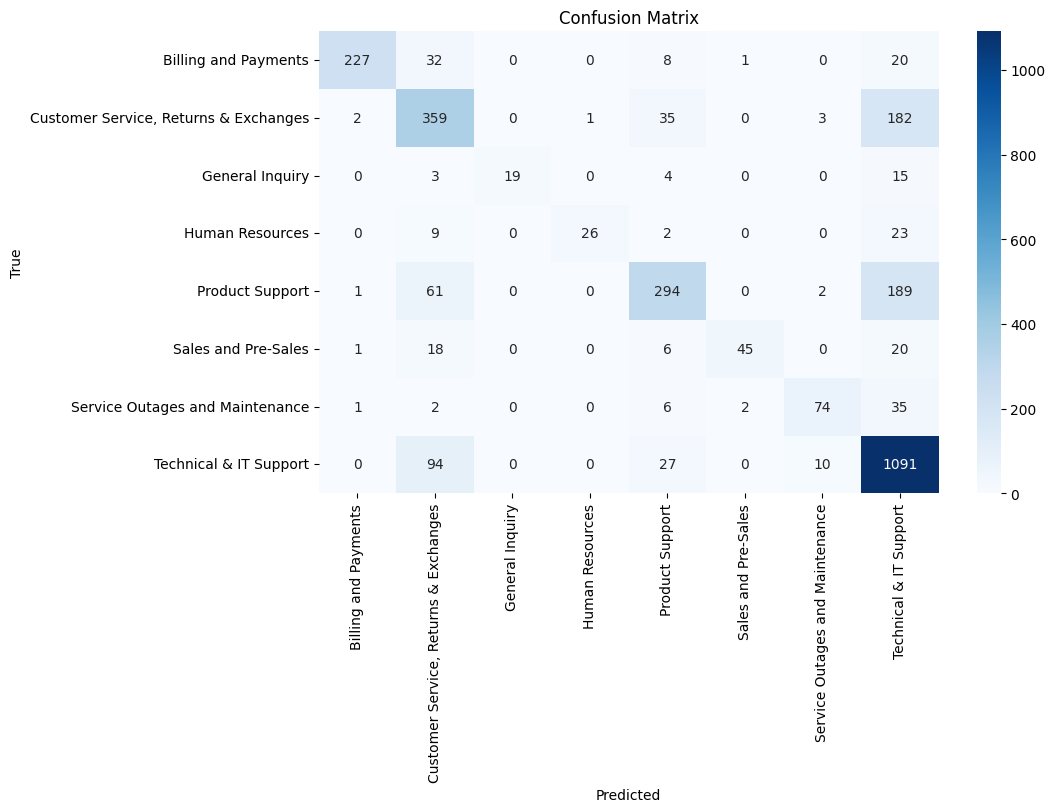

In [13]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The updated model shows improvement; the weighted F1 score increased from .66 to .72 in the test set. The most significant jump is seen in the `General Inquiry` queue, where F1 went from ~.26 to .63. This is evidence that the model is more balanced. Before tuning parameters, the model struggled to predict smaller classes, but now even these classes are showing improvements.

#### Interpretability
The model above uses embeddings, which are not human-interpable since the sentences were transformed into vectors. One way to better understand how the model makes it decides to view similar tickets. Tickets that are closer together are assumed to be semantically similar, so when we inspect the nearest neighbors, we get to see what neighboring samples the model sees when predictions are made.

In [51]:
show_nearest_tickets(
    query_index=42, 
    X_query=X_test, 
    X_ref=X_train, 
    df_query=test_df, 
    df_ref=train_df,
    n_neighbors=5,
    top_n=3
)

QUERY TICKET

Multiple hospital system applications, such as <NAME>, WhatsApp Desktop, and network switches, experienced outages and malfunctions, potentially leading to security vulnerabilities and network failures. Initial troubleshooting steps included rebooting systems, conducting network diagnostics, and performing security scans. Since the issue persists, urgent escalation is required. An investigation is necessary to identify the root cause and implement an appropriate solution. Your assistance and guidance from the team would be appreciated to resolve this matter.

Top 3 Most Similar Tickets in Reference Set (Sorted from Least to Most Similar):

----------------------------------------
Neighbor #1
Distance: 0.189
True Label: Service Outages and Maintenance
Text Preview:

Healthcare System Disruption The healthcare provider encountered an unforeseen outage, which disrupt
----------------------------------------

----------------------------------------
Neighbor #2
Distance: 0.18